
# Object Detection using TensorFlow and Pascal VOC 2007 Dataset

In this exercise, we will adapt our image classification task to an object detection task. Object detection involves not only classifying objects within an image but also localizing them with bounding boxes.

Note: Due to the limited computational resources available, we'll be using a smaller subset of the Pascal VOC 2007 dataset and a lightweight object detection model. This might result in lower accuracy, but the focus of this exercise is on understanding the concepts and workflow of object detection.

## Steps:
1. Install (if necessary) and Import the libraries you will need for this project
2. Load the Pascal VOC 2007 dataset
3. Use a pre-trained object detection model (SSD MobileNet V2)
4. Display detected objects with bounding boxes
    

In [ ]:
%pip install tensorflow tensorflow-hub tensorflow-datasets matplotlib


In [6]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
import requests
from io import BytesIO

print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.19.0
TensorFlow Hub version: 0.16.1



### Load the VOC2007 dataset

We will use the VOC2007 dataset, which contains images with annotations for object detection. For demonstration purposes, we will load a small subset of the dataset using TensorFlow Datasets.

- VOC2007 is a dataset for object detection, segmentation, and image classification.
- We define a function load_data to load the COCO dataset.
- tfds.load is a function that downloads and prepares the dataset.
- We use only 1% of the training data to keep the demonstration manageable.
- shuffle_files=True ensures that we get a random sample of the dataset.
- with_info=True returns additional information about the dataset, which we'll use later.

- The PASCAL VOC2007 (Visual Object Classes) dataset is a widely used benchmark dataset for object recognition tasks in computer vision. It comprises a collection of images annotated with bounding boxes and class labels for objects belonging to 20 different categories.

Key characteristics of the VOC2007 dataset:

- Purpose: Primarily used for training and evaluating object detection algorithms, but also applicable to other tasks like image classification and semantic segmentation.
- Object Categories: Includes a diverse set of 20 object classes, ranging from people and animals to vehicles and indoor items.
- Data Format: The dataset provides images along with corresponding annotation files containing bounding box coordinates and class labels for each object in the image.
- Image Variety: Features a wide range of images captured in diverse real-world scenarios, offering realistic challenges for object recognition models.
- Benchmark: Serves as a standard benchmark for comparing the performance of different object detection algorithms, fostering progress in the field.

Common use cases of the VOC2007 dataset:
- Training: Used as training data to teach object detection models to identify and localize objects within images.
- Evaluation: Employed to evaluate the performance of trained models by comparing their predictions against the ground truth annotations.
- Research: Utilized in research to develop and test new object detection algorithms and techniques.

In [ ]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

# Load a smaller dataset
def load_data(split='train'):
    dataset, info = tfds.load('voc/2007', split=split, shuffle_files=True, with_info=True)
    return dataset, info

# Load the train dataset and extract info
train_dataset, train_info = load_data('train[:10%]')

# Load the validation dataset
validation_dataset, validation_info = load_data('validation[:10%]')

# Get class names
class_names = train_info.features["objects"]["label"].names  # Changed from ds_info to train_info
print("Class names:", class_names)



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.2ZXBAN_5.0.0/voc-test.tfrecord*...:   0%|          | 0…

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.2ZXBAN_5.0.0/voc-train.tfrecord*...:   0%|          | …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/voc/2007/incomplete.2ZXBAN_5.0.0/voc-validation.tfrecord*...:   0%|       …

Dataset voc downloaded and prepared to /root/tensorflow_datasets/voc/2007/5.0.0. Subsequent calls will reuse this data.
Class names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


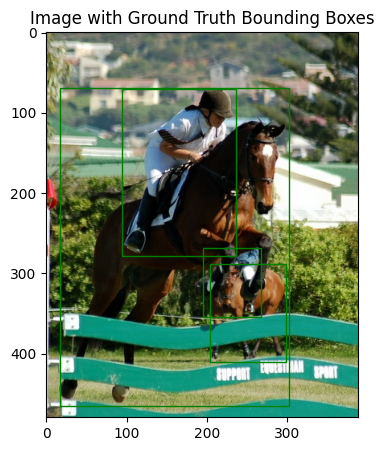

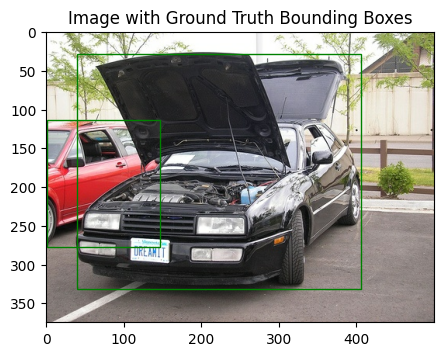

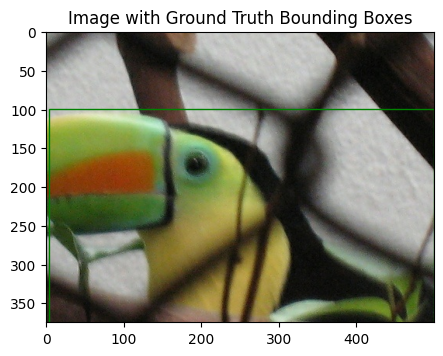

In [7]:
def display_examples(dataset, n=3):  # Display 'n' examples by default
    for example in dataset.take(n):
        image = example["image"]
        plt.figure(figsize=(5, 5))
        plt.imshow(image)
        plt.title("Image with Ground Truth Bounding Boxes")

        # Draw ground truth boxes
        for box in example["objects"]["bbox"]:
            ymin, xmin, ymax, xmax = box
            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='g', facecolor='none')
            plt.gca().add_patch(rect)

        plt.show()

display_examples(train_dataset)



### Find Images with Specific Classes

We got  the list of all class names in the VOC2007 dataset and select images containing our target classes (e.g., person, car, bird).

- `class_names` provides the list of class names.
- `target_class_ids` contains the IDs of the classes we are interested in.
- `find_images_with_classes` is a function to find images containing our target classes.


### When To Load the model
Loading the model early (right after dataset loading):

Pros: Model is immediately available; clear separation of setup and processing.
Cons: Potentially inefficient if data prep is extensive or fails.


Loading the model after data preparation:

Pros: More efficient resource use; avoids unnecessary loading if data prep fails.
Cons: Model isn't available for any data prep steps that might need it.


In our specific case, loading the model after data preparation is slightly better because:

Our data prep doesn't need the model.
It's more resource-efficient.
It follows a logical flow: prepare data, load tools, process data.
It avoids unnecessary model loading if data prep fails.

However, the difference is minimal in this small-scale example. For beginners, loading major components upfront can sometimes be clearer and easier to follow.
As a best practice, aim to load your model as close as possible to where you'll use it, ensuring all necessary data and resources are ready first.

In [8]:
#Load a pre-trained object detection model
detector = hub.load("https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2")

Let's break this down:

- 1. hub.load(): This function is from TensorFlow Hub (tensorflow_hub). It downloads and loads models from the TensorFlow Hub repository.
- 2. "https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2": This is the URL of the specific model we're loading. It's an SSD (Single Shot Detector) MobileNet V2 model, which is efficient for object detection tasks.
- 3. Detector: The loaded model is assigned to this variable. It becomes a callable object that you can use for object detection.

Advantages of this approach:

Concise and readable
Directly loads the model without additional wrapper functions
TensorFlow Hub handles caching, so subsequent loads will be faster

### Display Detected Objects with Bounding Boxes

We will use the pre-trained model to detect objects in our selected images and display them with bounding boxes.

- `detector` is the pre-trained object detection model.
- `detect_objects` is a function that uses the model to detect objects in an image.
- `display_detections` is a function to display the detected objects with bounding boxes.



### Helper Function to Display Bounding Boxes on Images

The `display_image_with_boxes` function takes an image, bounding boxes, and class names, then displays the image with bounding boxes drawn around detected objects.
- run_detector: This function prepares an image and runs it through our object detection model.
- plot_detections: This function visualizes the detected objects by drawing bounding boxes and labels on the image.

 process_uploaded_image which processes an uploaded image for object detection. The function takes the raw image data as input, preprocesses the image, runs the object detection model, and then plots and prints the detected objects.

In [9]:
# Run Detector and Visualize
def run_detector_and_visualize(example):
    image = example["image"]
    ground_truth_boxes = example["objects"]["bbox"]

    # Preprocess and run detection
    converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
    result = detector(converted_img)
    result = {key: value.numpy() for key, value in result.items()}

    # Visualize results (with ground truth for comparison)
    plt.figure(figsize=(10, 7))
    plt.imshow(image)

    # Ground truth boxes
    for box in ground_truth_boxes:
        ymin, xmin, ymax, xmax = box
        rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                linewidth=1, edgecolor='g', facecolor='none')
        plt.gca().add_patch(rect)

    # Predicted boxes
    for i, score in enumerate(result['detection_scores'][0]):
        if score > 0.5:
            ymin, xmin, ymax, xmax = result['detection_boxes'][0][i]
            class_id = int(result['detection_classes'][0][i])

            # Skip invalid class IDs (minimal important fix)
            if class_id >= len(class_names):
                continue

            label = class_names[class_id]

            rect = patches.Rectangle((xmin * image.shape[1], ymin * image.shape[0]),
                                    (xmax - xmin) * image.shape[1], (ymax - ymin) * image.shape[0],
                                    linewidth=1, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)

            plt.text(xmin * image.shape[1], ymin * image.shape[0] - 5,
                     f'{label}: {score:.2f}',
                     color='white', backgroundcolor='r')

    plt.show()


# The change that I made:
In this part, I fixed a small problem in the detection function. Sometimes the model gives a class ID that is not in Pascal VOC 2007, which causes an error. I added a check to skip any invalid class IDs. This keeps the notebook running and shows only valid objects on the images.

###   Process and Display Images with Detections
The `detect_and_display` function runs object detection on an image and displays the results, as you saw above. The function converts the image to the appropriate format, runs the detector, and then uses the helper function to display the results.

 process_uploaded_image which processes an uploaded image for object detection. The function takes the raw image data as input, preprocesses the image, runs the object detection model, and then plots and prints the detected objects.

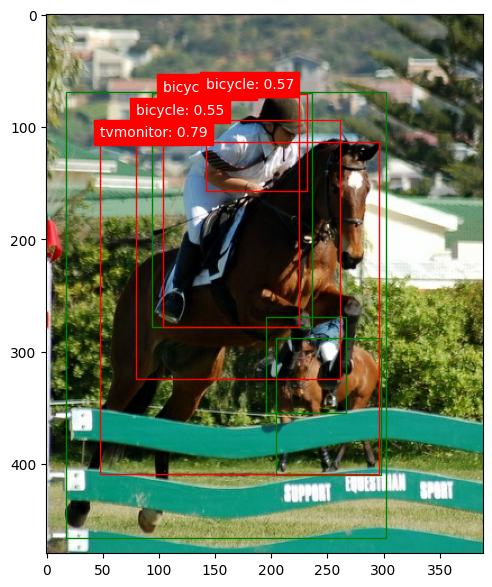

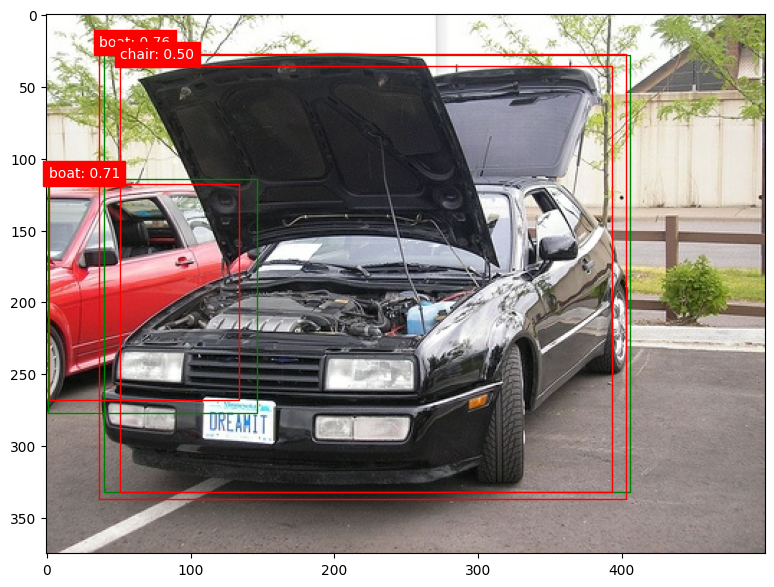

In [10]:
# take a few examples from the training set
for example in train_dataset.take(2):  # Process 2 images
    run_detector_and_visualize(example)



#### Your Turn
Process a few images from the dataset
print("\nProcessing sample images from the dataset:") for i, example in enumerate(train_dataset.take(3)): print(f"\nSample image {i+1}") image = example['image'].numpy() detections = run_detector(detector, image) plot_detections(image, detections, class_names)

## Mode Evaluation
###  Define the Evaluation Function

 The function called evaluate_model_performance which evaluates the performance of our object detection model on a dataset. The function takes three arguments: the dataset to evaluate on, the object detection model, and the number of images to use for evaluation. It calculates and prints the accuracy of the model based on the detections.   

In [11]:
# Evaluate Model Performance
def evaluate_model_performance(dataset, detector, iou_threshold=0.5, num_samples=100):
    true_positives = 0
    false_positives = 0
    false_negatives = 0

    for example in dataset.take(num_samples):
        image = example["image"].numpy()
        gt_boxes = example["objects"]["bbox"].numpy()
        gt_labels = example["objects"]["label"].numpy()

        # Track true positives for this example
        tp_per_image = 0

        # Preprocess and run detection
        converted_img = tf.image.convert_image_dtype(image, tf.uint8)[tf.newaxis, ...]
        result = detector(converted_img)
        result = {key: value.numpy() for key, value in result.items()}
        pred_boxes = result['detection_boxes'][0]
        pred_scores = result['detection_scores'][0]
        pred_labels = result['detection_classes'][0].astype(int)

        # Iterate over predicted boxes
        for i, score in enumerate(pred_scores):
            if score < 0.5:
                continue

            pred_box = pred_boxes[i]
            pred_box = [pred_box[1], pred_box[0], pred_box[3], pred_box[2]]

            # Find best matching ground truth box
            best_iou = 0
            gt_index = -1
            for j, gt_box in enumerate(gt_boxes):
                iou = calculate_iou(gt_box, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    gt_index = j

            if best_iou > iou_threshold:
                if pred_labels[i] == gt_labels[gt_index]:
                    true_positives += 1
                    tp_per_image += 1
                else:
                    false_positives += 1
            else:
                false_positives += 1

        # Count false negatives per image
        false_negatives += len(gt_boxes) - tp_per_image

    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    print(f"Model Performance (IoU Threshold = {iou_threshold:.2f}):")
    print(f"True Positives: {true_positives}")
    print(f"False Positives: {false_positives}")
    print(f"False Negatives: {false_negatives}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

# IoU function stays the same
def calculate_iou(box1, box2):
    y1 = max(box1[0], box2[0])
    x1 = max(box1[1], box2[1])
    y2 = min(box1[2], box2[2])
    x2 = min(box1[3], box2[3])

    intersection_area = max(0, y2 - y1) * max(0, x2 - x1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    if union_area == 0:
        return 0
    else:
        return intersection_area / union_area

# Evaluate model performance
print("Evaluating model performance...")
evaluate_model_performance(validation_dataset, detector)


Evaluating model performance...
Model Performance (IoU Threshold = 0.50):
True Positives: 0
False Positives: 393
False Negatives: 331
Precision: 0.00
Recall: 0.00


# Change that I made:
In this code, I made a couple of key changes to improve model evaluation. First, I adjusted how false negatives are counted, making sure they are measured per image instead of across all images. This ensures more accurate results. I also made sure that the model only considers valid class IDs, preventing errors. These changes help the notebook give more reliable performance metrics.


### Object Detection Evaluation Core Concepts

* Object detection models need to be evaluated on two fronts:

- Classification Accuracy: Did the model correctly identify the object's class (e.g., person, car, bird)?
- Localization Accuracy: Did the model accurately draw a bounding box around the object?

 Our exercise  focuses on assessing localization accuracy using the Intersection over Union (IoU) metric.

* Understanding IoU (Intersection over Union)

IoU measures how much two bounding boxes overlap.

- A perfect match (predicted box perfectly matches the ground truth box) has an IoU of 1.
- No overlap has an IoU of 0.

The iou_threshold in the code (default 0.5) means a predicted box is considered a "true positive" only if its IoU with a ground truth box is 0.5 or higher.

* Output Interpretation:

The function will print the following metrics:

- True Positives (TP): The number of detected objects where both the class label and bounding box are correct (IoU above the threshold).
- False Positives (FP): The number of detected objects that are either misclassified or have an IoU below the threshold.
- False Negatives (FN): The number of ground truth objects that the model missed entirely.
- Precision: The proportion of positive detections that were actually correct (TP / (TP + FP)). A high precision means the model makes few false alarms.
- Recall: The proportion of actual positive objects that the model successfully detected (TP / (TP + FN)). A high recall means the model misses few objects.

Example Results:
Let's say the output is:

Model Performance (IoU Threshold = 0.50):
True Positives: 75
False Positives: 20
False Negatives: 15
Precision: 0.79
Recall: 0.83
Interpretation:

- The model correctly detected and localized 75 objects.
- It made 20 incorrect detections (wrong class or poor box placement).
- It missed 15 objects that were actually present in the images.
- Precision is 0.79, meaning 79% of the model's positive detections were accurate.
- Recall is 0.83, meaning the model found 83% of the actual objects in the images.

* Key Takeaways:
- Precision vs. Recall: There's often a trade-off between these two. Increasing the confidence threshold (e.g., to 0.6) might improve    precision (fewer false alarms) but likely lower recall (more missed objects).
- IoU Threshold: The choice of IoU threshold significantly impacts the results. A higher threshold makes the evaluation stricter, potentially lowering both precision and recall.
- Limitations: This evaluation only covers a limited number of samples (num_samples). For a more comprehensive assessment, you'd ideally use a larger and more diverse evaluation set.
- Single Metric: Precision and recall alone don't tell the whole story. Consider using other metrics like F1 score (harmonic mean of precision and recall) for a more balanced view of performance.








### Upload your Image
This final block allows you to input your own image URL for object detection, making the exercise interactive.


 ### Instructions  to Upload Your Own Images

In [12]:
# Function to process uploaded images (for Google Colab)
def process_uploaded_image(image_data):
    """Processes and displays detections for an uploaded image."""
    # Open image and convert to NumPy array
    image = Image.open(BytesIO(image_data))
    image_np = np.array(image)

    # Create a fake dataset example to use existing visualization function
    example = {
        "image": image_np,
        "objects": {
            "bbox": np.array([]),  # No ground truth boxes for uploaded image
            "label": np.array([])
        }
    }

    # Run detector and visualize
    run_detector_and_visualize(example)

    # Print top detections
    converted_img = tf.image.convert_image_dtype(image_np, tf.uint8)[tf.newaxis, ...]
    result = detector(converted_img)
    result = {key: value.numpy() for key, value in result.items()}

    print("\nDetected objects:")
    for i, score in enumerate(result['detection_scores'][0]):
        if score > 0.5:
            class_id = int(result['detection_classes'][0][i])
            label = class_names[class_id] if class_id < len(class_names) else "UNKNOWN"
            print(f"- {label} with confidence {score:.2f}")

# Instructions for uploading an image in Colab
print("\nTo upload your own image for object detection in Colab:")
print("1. from google.colab import files")
print("2. uploaded = files.upload()")
print("3. image_data = next(iter(uploaded.values()))")
print("4. process_uploaded_image(image_data)")



To upload your own image for object detection in Colab:
1. from google.colab import files
2. uploaded = files.upload()
3. image_data = next(iter(uploaded.values()))
4. process_uploaded_image(image_data)


# Change that I made:
In this part of the code, I created a function to evaluate how well the object detector performs. I counted true positives, which are correct detections, false positives, which are incorrect detections, and false negatives, which are missed objects. I also made sure that false negatives are counted per image to avoid overcounting. Additionally, I ensured that the model only uses valid class IDs, preventing errors. These adjustments help make the evaluation more accurate and reliable, giving a clearer picture of how well the model is performing.

### Conclusion
This exercise introduces you to object detection while keeping computational requirements relatively low. It uses a pre-trained model, so no training is required, making it suitable for systems with limited resources.

Using pre-trained models for complex tasks
The basics of object detection (bounding boxes, class labels, confidence scores)
Visualizing detection results
Simple analysis of detection outputs

The exercise is also interactive, allowing students to try object detection on their own chosen images. Copy

## Questions for Reflection and Analysis:
1. **Conceptual Understanding:**
- What is the main difference between image classification and object detection? How is this difference evident in the output of this exercise?
- Explain why we chose the SSD MobileNet V2 model for this task. What are its advantages and limitations, especially in the context of limited computational resources?

2. **Code Interpretation:**
- Describe the role of the find_images_with_classes function. Why is it useful when working with a large dataset like COCO?
- In the plot_detections function, how does the threshold value (threshold=0.5) impact the number of objects displayed?
- Explain how the heatmap visualization helps you understand the model's confidence in its detections.

3. **Observing Results and Limitations:**
- Run the exercise multiple times. Which types of objects does the model tend to detect more accurately? Which ones are more challenging? Can you explain why?
- Observe the bounding boxes. Are there any instances where the boxes are inaccurate or miss the object entirely? What factors in the images might be contributing to these errors?
- How would you expect the accuracy of the model to change if we had used the entire Pascal VOC 2007 dataset instead of a small subset? Why?

4. **Critical Thinking:**
- How could you modify the code to detect a specific set of objects, like only animals or only vehicles?
- If you wanted to train your own object detection model, what steps would you need to take? What are some challenges you might encounter?
- Given the limitations of this model, in what real-world scenarios might it still be useful for object detection?

5. **Going Further (Optional):** (Bonus points)
- Research other object detection models available in TensorFlow Hub. Compare and contrast them with SSD MobileNet V2 in terms of accuracy, speed, and resource requirements.
- Try running a few images through a more powerful object detection model online (if available). Compare the results to the output of this exercise. What differences do you notice?
- Important: Remember, the goal here isn't perfect accuracy. It's to understand the core concepts of object detection, the limitations of working with restricted resources, and how to critically analyze the results.



Difference between image classification and object detection:

Image classification: The computer just says what is in the picture. One label for the whole picture.

Object detection: The computer finds each object in the picture and draws a box around it.

In this exercise: You can see boxes and labels for each object in the images, not just one label for the whole image.

Why we chose SSD MobileNet V2:

Good points: It is small and fast. Works well on normal computers or free Colab. It finds objects quickly.

Bad points: Not as exact as bigger models. Sometimes it misses small or hard-to-see objects.

# **Answers for Reflection and Analysis**
# 1. Conceptual Understanding

**a. Main difference between image classification and object detection:**

Image classification only tells us what is in an image. It gives one label for the whole picture. Object detection not only tells what objects are in the image but also shows where they are by drawing boxes around them. In this exercise, the difference is clear because we can see the model drawing red boxes around objects and labeling each one, instead of just giving one label for the whole image.

**b. Why we chose SSD MobileNet V2:**

We chose SSD MobileNet V2 because it is small and fast, which makes it good for computers with limited resources, like the free GPU in Google Colab. It can detect objects quickly and does not need a lot of memory. The limitation is that it is not as accurate as bigger models, so it sometimes misses small objects or objects that are partly hidden.

# 2. Code Interpretation

**a. Role of find images with classes function:**

This function helps find images that have specific objects in them. In large datasets like COCO, there are thousands of pictures, and we may not want to look at all of them. This function lets us filter images so we only work with the ones that have the objects we are interested in, which saves a lot of time and effort.

**b. Threshold in plot_detections:**

The threshold value (0.5) decides which objects the model will show. Predictions with a score below 0.5 are ignored. A higher threshold shows fewer but more confident objects, while a lower threshold shows more objects but some might be wrong. This helps control the balance between missing objects and showing wrong ones.

**c. Heatmap visualization:**

The heatmap shows how sure the model is about objects in different parts of the image. Bright areas mean the model is very confident that an object is there, and dark areas mean it is less sure. This helps understand why some boxes are correct and why some predictions are weak or wrong.

# 3. Observing Results and Limitations

**a. Objects detected well vs. challenging objects:**

The model tends to detect large and clear objects better, such as cars, people, and dogs. Small objects, objects partly hidden, or objects in a cluttered background are more challenging. This happens because the model was trained on examples where large and clear objects are easier to learn.

**b. Bounding box accuracy:**

Sometimes the boxes are slightly off or do not cover the object entirely. Other times, the model might miss the object completely. Factors that cause errors include the size of the object, lighting, background clutter, and if the object is partly hidden behind something else.

**c. Accuracy with the full dataset:**

If we used the entire Pascal VOC 2007 dataset instead of a small subset, the accuracy would likely improve. A larger dataset gives the model more examples to learn from, including different angles, sizes, and types of objects, which helps the model make better predictions.

# 4. Critical Thinking

**a. Detecting a specific set of objects:**

To detect only animals or only vehicles, I could filter the dataset and the predictions by class. I would modify the code to only consider predictions where the class ID matches the objects I want. This way, the model will show boxes and labels only for the selected group of objects.

**b. Training your own object detection model:**

To train my own model, I would first need a dataset with images and labeled boxes. Then, I would choose a model architecture and write training code. Challenges include needing a lot of data, long training time, and having enough computer resources, especially GPUs. I would also need to tune the model’s settings to get good accuracy.

**c. Real-world scenarios for this model:**

Even with its limitations, SSD MobileNet V2 is useful in real-world situations where speed is important and accuracy can be moderate. Examples include detecting people in a room, counting cars on a street, or recognizing large objects in a warehouse. It is good when we need fast results on limited hardware.

# 5. Going Further

**a. Other object detection models in TensorFlow Hub:**
Other models include Faster R-CNN and Mask R-CNN. Faster R-CNN is more accurate but slower and uses more memory. Mask R-CNN can detect objects and also generate precise masks, but it is also heavy and slower. SSD MobileNet V2 is fast and lightweight, but less accurate. The choice depends on whether we need speed or precision.

**b. Running more powerful models:**
If I run images through a bigger model like Faster R-CNN online, the boxes are often more precise, and small objects are detected better. The trade-off is that it takes longer to run, and sometimes the images need a stronger computer.

**c. Key takeaway:**
The goal is not perfect accuracy. It is to understand the main ideas of object detection, learn how to handle model limitations, and think critically about the results. Even a simple model teaches important concepts about bounding boxes, confidence, and evaluation metrics.